# 1. Replace the GRU by an LSTM and compare the accuracy and training speed.

In [2]:
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")
from sklearn.model_selection import ParameterGrid

class LSTM(d2l.RNN):  #@save
    """The multilayer GRU model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)

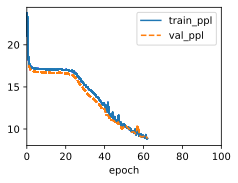

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1)
trainer.fit(model, data)

# 2. Increase the training data to include multiple books. How low can you go on the perplexity scale?

In [ ]:
def hash_file(fname):
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        return sha1.hexdigest()
    
class Book(d2l.DataModule):
    def _download(self):
        fname = d2l.download(self.url, self.root, hash_file(os.path.join(self.root, self.url.split('/')[-1])))
        with open(fname) as f:
            return f.read()
        
    def __init__(self, url, batch_size, num_steps, num_train=10000, num_val=5000):
        """Defined in :numref:`sec_language-model`"""
        super().__init__()
        self.save_hyperparameters()
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]
        
    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        return list(text)
    
    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = d2l.Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab
        
    def get_dataloader(self, train):
        """Defined in :numref:`subsec_partitioning-seqs`"""
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)
        
    
class MulBooks(d2l.DataModule):
    def __init__(self, books):
        x_list = []
        y_list = []
        self.num_train = 0
        self.num_val = 0
        for book in books:
            x_list.append(book.X)
            y_list.append(book.Y)
            self.num_train += book.num_train
            self.num_val += book.num_val
        
    def get_dataloader(self, train):
        """Defined in :numref:`subsec_partitioning-seqs`"""
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)

In [ ]:
urls = ['https://www.gutenberg.org/cache/epub/36/pg36.txt','https://www.gutenberg.org/cache/epub/71557/pg71557.txt','http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt']
books = [Book(url=url, batch_size=1024, num_steps=32) for url in urls]
data = MulBooks(books)
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1)
trainer.fit(model, data)

# 3. Would you want to combine sources of different authors when modeling text? Why is this a good idea? What could go wrong?

Combining sources of different authors when modeling text can be a good idea for several reasons. First, it can help to enrich the vocabulary, style, and diversity of the text, as different authors may use different words, expressions, and perspectives to convey their ideas. Second, it can help to improve the accuracy, reliability, and credibility of the text, as different authors may provide different evidence, arguments, and evaluations to support their claims. Third, it can help to enhance the creativity, originality, and novelty of the text, as different authors may inspire new insights, connections, and solutions to the problem at hand.

However, combining sources of different authors when modeling text can also pose some challenges and risks. First, it can be difficult to integrate the sources smoothly and coherently, as different authors may have different focuses, purposes, and structures in their texts. Second, it can be hard to avoid plagiarism and maintain academic integrity, as different authors may have different rights and permissions for their texts. Third, it can be tricky to balance the sources and avoid bias or distortion, as different authors may have different opinions, assumptions, and values in their texts.

Therefore, when combining sources of different authors when modeling text, one should be careful and critical in selecting, analyzing, synthesizing, and citing the sources. One should also follow the conventions and guidelines of the specific genre, discipline, and audience for which the text is intended. For more information on how to compare and synthesize sources for text modeling, you can refer to some of the web search results I found for you: [Learning to rank for multi-label text classification](^1^), [Comparing and Synthesizing Sources](^2^), [APA In-Text Citations](^3^).


- (1) Learning to rank for multi-label text classification: Combining .... https://www.cambridge.org/core/journals/natural-language-engineering/article/learning-to-rank-for-multilabel-text-classification-combining-different-sources-of-information/C08E945A2D2B547020A439AE41610C59.
- (2) 9 COMPARING AND SYNTHESIZING SOURCES - Colorado .... https://writing.colostate.edu/textbooks/informedwriter/chapter9.pdf.
- (3) APA In-Text Citations (7th Ed.) | Multiple Authors & Missing Info. https://www.scribbr.com/apa-style/in-text-citation/.
- (4) undefined. https://doi.org/10.1017/S1351324920000029.
- (5) undefined. http://creativecommons.org/licenses/by/4.0/.